In [1]:
%%capture
# If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed
!pip install --no-index /kaggle/input/making-wheels-of-necessary-packages-for-hf-llms/bitsandbytes-0.42.0-py3-none-any.whl --find-links=/kaggle/input/making-wheels-of-necessary-packages-for-hf-llms
!pip install --no-index /kaggle/input/making-wheels-of-necessary-packages-for-hf-llms/accelerate-0.27.2-py3-none-any.whl --find-links=/kaggle/input/making-wheels-of-necessary-packages-for-hf-llms
!pip install --no-index /kaggle/input/making-wheels-of-necessary-packages-for-hf-llms/transformers-4.38.1-py3-none-any.whl --find-links=/kaggle/input/making-wheels-of-necessary-packages-for-hf-llms
!pip install --no-index /kaggle/input/making-wheels-of-necessary-packages-for-hf-llms/optimum-1.17.1-py3-none-any.whl --find-links=/kaggle/input/making-wheels-of-necessary-packages-for-hf-llms

In [2]:
! pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 11.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 42.8 MB/s eta 0:00:0000:0100:01m


In [3]:
! pip install pdfminer.six

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.2 MB/s eta 0:00:00a 0:00:01


In [4]:
!pip install numba
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=8220a3a2b0790000fd05f5e0151c4e29a3e3660506710b88727a9a016a96854e
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [5]:
! sudo sync; echo 3 > /proc/sys/vm/drop_caches

/bin/bash: /proc/sys/vm/drop_caches: Read-only file system


In [6]:
from accelerate.utils import BnbQuantizationConfig
from accelerate import Accelerator
import transformers
import optimum
import bitsandbytes
import re


In [7]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  2% |  1% |
|  1 |  0% |  0% |


In [8]:
import torch
from transformers import BitsAndBytesConfig
import requests
from PIL import Image

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

In [9]:
from transformers import pipeline
def load_llava():
    model_id = "llava-hf/llava-1.5-7b-hf"

    pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})
    return pipe

2024-04-21 08:37:55.811092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 08:37:55.811185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 08:37:55.921591: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
import fitz  # PyMuPDF
from IPython.display import display, HTML
import torch
from PIL import Image
import io

def extract_and_caption_images_from_pdf(pdf_path, pipe):
    # Open the provided PDF
    doc = fitz.open(pdf_path)
    
    # Store all extracted images as PIL Images
    outputs = []
    
    # Iterate through each page
    for i in range(len(doc)):
        page = doc.load_page(i)
        
        # Extract images
        for image_index, img in enumerate(page.get_images(full=True)):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            
            # Convert bytes to a PIL Image
            image = Image.open(io.BytesIO(image_bytes))
            if image.mode != "RGB":
                image = image.convert("RGB")
            display(image)
            output = pipe(image, prompt=prompt2, generate_kwargs={"max_new_tokens": 200})
            print(output)
            outputs.append(output)

max_new_tokens = 200
prompt = "USER: <image>\nWhat are the things I should be cautious about when I visit this place?\nASSISTANT:"
prompt2 = "USER: <image>\nCan you describe this picture, considering that these content are related to Machine learning specifically Linear regression? \nASSISTANT:"
pdf_file_path = "/kaggle/input/pdffile/2-Linear_classification.pdf"  # Adjust as per your path
#extract_and_caption_images_from_pdf(pdf_file_path, pipe)

Text from Page 1:
Text from Previous Page 1:
Streaming Data Analytics
Administrative items
Emanuele Della Valle
prof @ Politecnico di Milano
emanuele.dellavalle@polimi.it
http://emanueledellavalle.org
Emanuele Della Valle - http://emanueledellavalle.org
1

Text from Current Page 2:
About me
Emanuele Della Valle
— Associate Professor, DEIB, Politecnico di 
Milano, Italy 
— 20+ years between academia and industry
— Expert in Semantic Technologies and 
Stream Processing
— Brander of Stream Reasoning
— Serial startupper :-P
Emanuele Della Valle - http://emanueledellavalle.org
2

Text from Next Page 3:
Lectures' Timetable
— Official
— Wednesday 14:15 - 16:15 in classroom 5.02
— Thursday 16:15 - 18:15 in classroom 21.S.2
— Pragmatically
— Tuesday 14:30 - 16:00 in classroom 5.02 
— Thursday 16:15 - 17:45 in classroom 21.S.2
— Important NOTES
— there is no clear cut between theory and practice
— bring your laptops we will often code
— I record ALL lectures but I do not stream them
Emanuele Del

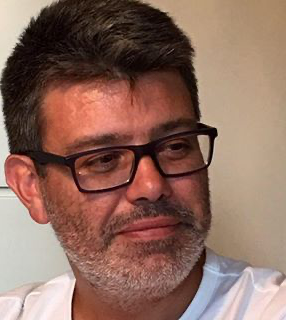

Text from Page 4:
Text from Previous Page 4:
Lectures' Recording
— I record all lectures, and I make them available the same day
— I do not stream the lectures outside the classroom (i.e., I can selectively 
admit people who are in the room)
Emanuele Della Valle - http://emanueledellavalle.org
4

Text from Current Page 5:
Objetives
The course provides the foundational concepts, 
methods, languages, and systems for ingesting, 
processing, and analyzing data that flows to 
enable real-time decisions. 
The course aims to tame the velocity 
dimensions of Big Data without forgetting the 
volume and variety dimensions.
Emanuele Della Valle - http://emanueledellavalle.org
5

Text from Next Page 6:
Prerequisites
Students are expected to know the basics of database management and SQL 
Emanuele Della Valle - http://emanueledellavalle.org
6

Displaying images from Page 5:


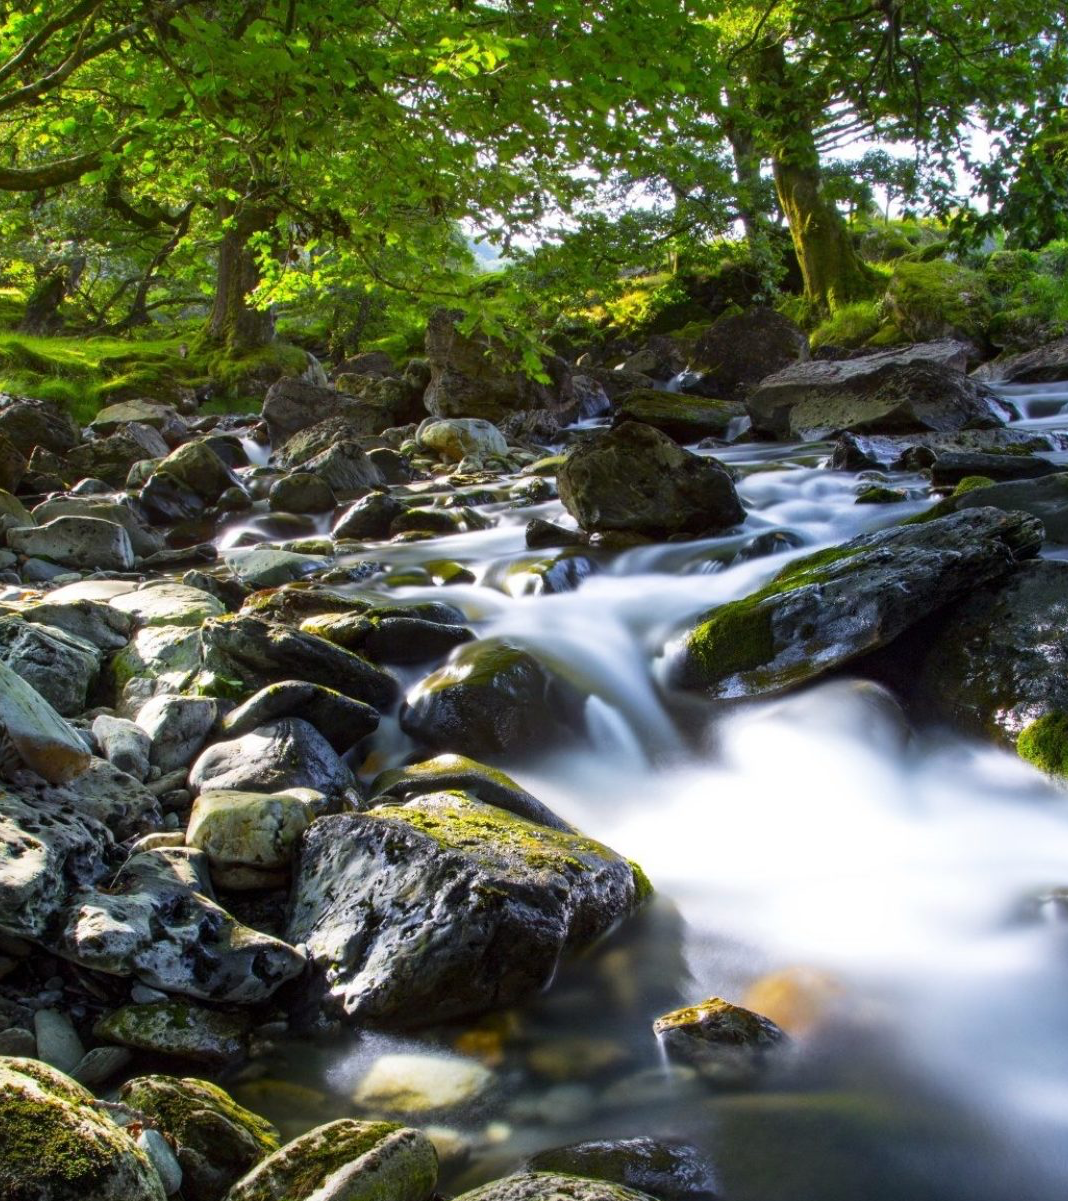

In [11]:
import fitz  # Import PyMuPDF
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextBox, LTTextLine
from PIL import Image
import io

def find_pages_with_images(pdf_path):
    doc = fitz.open(pdf_path)
    pages_with_images = set()
    for page_number, page in enumerate(doc):
        if page.get_image_info():
            pages_with_images.add(page_number)
    doc.close()
    return pages_with_images

def extract_relevant_text_and_display_images(pdf_path, pages_with_images):
    doc = fitz.open(pdf_path)  # Open the PDF with PyMuPDF for image extraction
    pdf_text = {page_number: "" for page_number in range(len(doc))}  # Dictionary to store text of all pages

    # Extract text from all pages
    for page_number, page_layout in enumerate(extract_pages(pdf_path)):
        for element in page_layout:
            if isinstance(element, LTTextBox) or isinstance(element, LTTextLine):
                pdf_text[page_number] += element.get_text()
    text = []
    temp = ""
    images = []
    # Process each page for relevant text and images
    for page_number in sorted(pages_with_images):
        # Check and display text from the previous page, current page, and the next page
        print(f"Text from Page {page_number}:")
        if page_number > 0:  # Previous page text
            print(f"Text from Previous Page {page_number}:")
            print(pdf_text[page_number - 1])
            temp += pdf_text[page_number - 1]
        print(f"Text from Current Page {page_number + 1}:")  # Current page text
        print(pdf_text[page_number])
        temp += pdf_text[page_number]
        if page_number + 1 < len(doc):  # Next page text
            print(f"Text from Next Page {page_number + 2}:")
            print(pdf_text[page_number + 1])
            temp += pdf_text[page_number]
        text.append(temp)
        

        # Display images from the current page
        print(f"Displaying images from Page {page_number + 1}:")
        page = doc[page_number]
        for image_index, img in enumerate(page.get_images(full=True)):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            image = Image.open(io.BytesIO(image_bytes))
            if image.mode != "RGB":
                image = image.convert("RGB")
            display(image)
            images.append(image)
            #image_stream.close()
    doc.close()
    return images, text

# Usage
pdf_file_path = "/kaggle/input/pdf-file/00.pdf"
pages_with_images = find_pages_with_images(pdf_file_path)
images, texts = extract_relevant_text_and_display_images(pdf_file_path, pages_with_images)

In [12]:
from pdfminer.layout import LAParams, LTTextBox, LTTextLine

def extract_text_from_pdf_page_by_page(pdf_path):
    # Using extract_pages to get more control over each page
    for page_layout in extract_pages(pdf_path):
        # Initialize an empty string to collect text
        page_text = ''
        # Iterate over whatever the parser finds on the page
        for element in page_layout:
            if isinstance(element, LTTextBox) or isinstance(element, LTTextLine):
                page_text += element.get_text()
        # Yield or print each page's text separately
        yield page_text

# Usage
pdf_file_path = '/kaggle/input/pdf-file/00.pdf'
text = ""
for page_number, page_text in enumerate(extract_text_from_pdf_page_by_page(pdf_file_path), 1):
    text += page_text

In [13]:
text

'Streaming Data Analytics\nAdministrative items\nEmanuele Della Valle\nprof @ Politecnico di Milano\nemanuele.dellavalle@polimi.it\nhttp://emanueledellavalle.org\nEmanuele Della Valle - http://emanueledellavalle.org\n1\nAbout me\nEmanuele Della Valle\n— Associate Professor, DEIB, Politecnico di \nMilano, Italy \n— 20+ years between academia and industry\n— Expert in Semantic Technologies and \nStream Processing\n— Brander of Stream Reasoning\n— Serial startupper :-P\nEmanuele Della Valle - http://emanueledellavalle.org\n2\nLectures\' Timetable\n— Official\n— Wednesday 14:15 - 16:15 in classroom 5.02\n— Thursday 16:15 - 18:15 in classroom 21.S.2\n— Pragmatically\n— Tuesday 14:30 - 16:00 in classroom 5.02 \n— Thursday 16:15 - 17:45 in classroom 21.S.2\n— Important NOTES\n— there is no clear cut between theory and practice\n— bring your laptops we will often code\n— I record ALL lectures but I do not stream them\nEmanuele Della Valle - http://emanueledellavalle.org\n3\nLectures\' Recordin

In [14]:
text = text[:2000]

In [15]:
len(text)

2000

In [16]:
text

"Streaming Data Analytics\nAdministrative items\nEmanuele Della Valle\nprof @ Politecnico di Milano\nemanuele.dellavalle@polimi.it\nhttp://emanueledellavalle.org\nEmanuele Della Valle - http://emanueledellavalle.org\n1\nAbout me\nEmanuele Della Valle\n— Associate Professor, DEIB, Politecnico di \nMilano, Italy \n— 20+ years between academia and industry\n— Expert in Semantic Technologies and \nStream Processing\n— Brander of Stream Reasoning\n— Serial startupper :-P\nEmanuele Della Valle - http://emanueledellavalle.org\n2\nLectures' Timetable\n— Official\n— Wednesday 14:15 - 16:15 in classroom 5.02\n— Thursday 16:15 - 18:15 in classroom 21.S.2\n— Pragmatically\n— Tuesday 14:30 - 16:00 in classroom 5.02 \n— Thursday 16:15 - 17:45 in classroom 21.S.2\n— Important NOTES\n— there is no clear cut between theory and practice\n— bring your laptops we will often code\n— I record ALL lectures but I do not stream them\nEmanuele Della Valle - http://emanueledellavalle.org\n3\nLectures' Recording\

In [17]:
llava_model = load_llava()

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

In [18]:
prompt2 = """USER: <image>\n Please generate a descriptive paragraph based on the provided image, focusing only on the context information provided below. Avoid incorporating details not mentioned in the"{context}". Focuse on the keywords and topic of the context. \nASSISTANT:"""
outputs = llava_model(images[1], prompt=prompt2.format(context=texts[1]), generate_kwargs={"max_new_tokens": 1000})

In [19]:
outputs

[{'generated_text': 'USER:  \n Please generate a descriptive paragraph based on the provided image, focusing only on the context information provided below. Avoid incorporating details not mentioned in the"Streaming Data Analytics\nAdministrative items\nEmanuele Della Valle\nprof @ Politecnico di Milano\nemanuele.dellavalle@polimi.it\nhttp://emanueledellavalle.org\nEmanuele Della Valle - http://emanueledellavalle.org\n1\nAbout me\nEmanuele Della Valle\n— Associate Professor, DEIB, Politecnico di \nMilano, Italy \n— 20+ years between academia and industry\n— Expert in Semantic Technologies and \nStream Processing\n— Brander of Stream Reasoning\n— Serial startupper :-P\nEmanuele Della Valle - http://emanueledellavalle.org\n2\nAbout me\nEmanuele Della Valle\n— Associate Professor, DEIB, Politecnico di \nMilano, Italy \n— 20+ years between academia and industry\n— Expert in Semantic Technologies and \nStream Processing\n— Brander of Stream Reasoning\n— Serial startupper :-P\nEmanuele Della

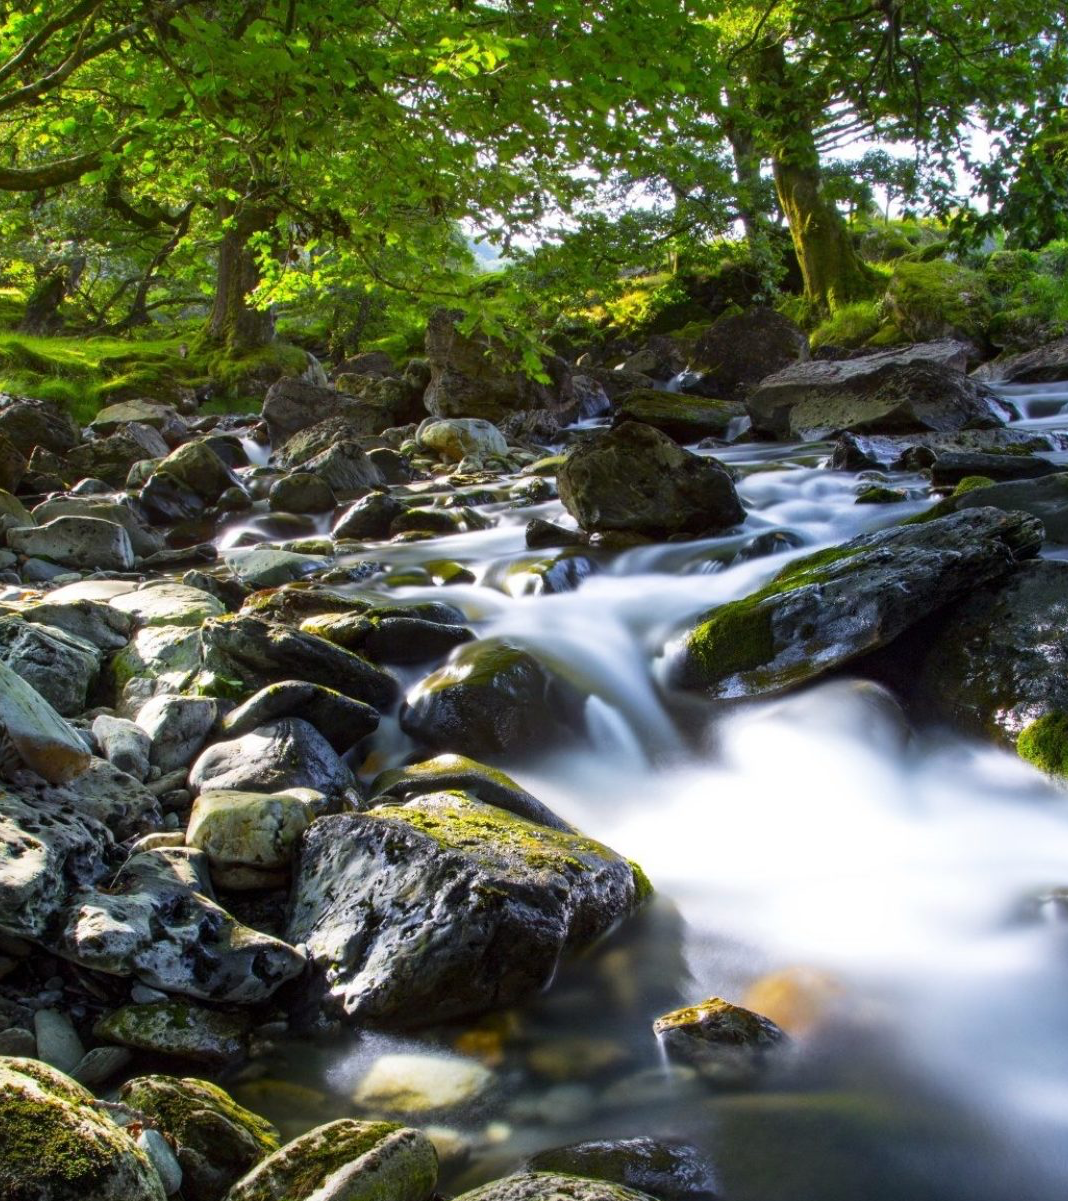

In [21]:
display(images[1])